<a href="https://colab.research.google.com/github/MJ199999/SW-Project/blob/master/code/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.3 MB/s 
     |████████████████████████████████| 6.6 MB 66.5 MB/s 
     |████████████████████████████████| 120 kB 56.5 MB/s 


# 2. Data Load & Simple Preprocess

In [ ]:
!wget https://github.com/MJ199999/SW-Project/raw/master/poem_key.xlsx

--2022-09-12 04:38:02--  https://github.com/MJ199999/SW-Project/raw/master/poem_key.xlsx
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MJ199999/SW-Project/master/poem_key.xlsx [following]
--2022-09-12 04:38:02--  https://raw.githubusercontent.com/MJ199999/SW-Project/master/poem_key.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236384 (231K) [application/octet-stream]
Saving to: ‘poem_key.xlsx’

poem_key.xlsx       100%[===================>] 230.84K  --.-KB/s    in 0.02s   

2022-09-12 04:38:03 (14.5 MB/s) - ‘poem_key.xlsx’ saved [236384/236384]



In [ ]:
import pandas as pd

df = pd.read_excel('/content/poem_key.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  437 non-null    int64 
 1   시           437 non-null    object
 2   키워드 전체      437 non-null    object
 3   키워드1        437 non-null    object
 4   키워드2        437 non-null    object
 5   키워드3        437 non-null    object
 6   키워드4        437 non-null    object
 7   키워드5        437 non-null    object
dtypes: int64(1), object(7)
memory usage: 27.4+ KB


In [ ]:
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_dataset = df

# 3. Load Tokenizer & GPT3 Model

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5", bos_token='</s>', eos_token='</s>', pad_token='<pad>')
# gpt3_model = TFAutoModelForCausalLM.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5", from_pt=True)

In [ ]:
gpt3_model = TFAutoModelForCausalLM.from_pretrained("MJ199999/gpt3_model")

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at MJ199999/gpt3_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
tokenizer.add_tokens(['newWord', 'newWord2'])

2

In [ ]:
gpt3_model.resize_token_embeddings(len(tokenizer))

In [ ]:
print(tokenizer.encode(df['시'].loc[0]))
print(tokenizer.tokenize(df['시'].loc[0]))
print(tokenizer.decode(tokenizer.encode(df['시'].loc[0])))

[31171, 36238, 30726, 33577, 30298, 376, 18792, 22688, 30696, 30198, 31634, 21068, 50647, 35706, 21788, 30005, 25624, 30417, 30697, 30397, 32051, 25512, 30279, 34310, 376, 25624, 42027, 30044, 42027, 30031, 31366, 42859, 51138, 30298, 30005, 376, 29880, 31570, 33401, 24196, 30121, 22692, 20160, 25404, 376, 25960, 32086, 31241, 37797, 30092, 34682, 39172, 376, 26213, 25768, 32051, 46222, 50272, 30312, 35673, 30005, 25260, 34551, 30865, 40981, 37254, 23272, 34509, 25628, 47102, 35306, 20476, 30298, 30005, 376, 36225, 19968, 30328, 31203, 376, 23280, 21956, 31082, 21900, 30589, 23028, 24784, 565, 24471, 25820, 30164, 35031, 34264, 376, 24224, 31517, 30093, 36902, 37556, 48481, 21076, 19016, 34179, 30005, 376, 22324, 30284, 40624, 41204, 43205, 25428, 376, 25960, 30093, 30288, 32767, 40659, 29880, 30688, 30134, 21956, 31082, 34257, 29152, 24644, 24644, 31793, 24644, 24644, 30093, 32198, 30248, 42859, 30023, 30441, 376, 25492, 31296, 40455, 29979, 27588, 376, 20091, 19016, 43308, 31891, 219

# 4. Tokenize Keywords & Poems

In [ ]:
max_seq_len = 180

In [ ]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, data_labels = [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=180, value=tokenizer.pad_token_id, padding='post')[0]

        output_tokens = bos_token + tokenizer.tokenize(label) + eos_token
        output_id = tokenizer.convert_tokens_to_ids(output_tokens)
        output_id = pad_sequences([output_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]
        
        assert len(input_id) == 180, "Error with inpxut length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(output_id)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.array(data_labels, dtype=int)
    # data_labels = np.array(data_labels, dtype=int).reshape((-1,1))


    return input_ids, data_labels

# 5. Set Train Data

In [ ]:
train_X_1, train_y = convert_examples_to_features(train_dataset['키워드1'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 543/543 [00:00<00:00, 1217.52it/s]


In [ ]:
train_X_2, train_y = convert_examples_to_features(train_dataset['키워드2'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 543/543 [00:00<00:00, 1227.95it/s]


In [ ]:
train_X_3, train_y = convert_examples_to_features(train_dataset['키워드3'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 543/543 [00:00<00:00, 1255.33it/s]


In [ ]:
train_X_4, train_y = convert_examples_to_features(train_dataset['키워드4'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 543/543 [00:00<00:00, 1263.27it/s]


In [ ]:
train_X_5, train_y = convert_examples_to_features(train_dataset['키워드5'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 543/543 [00:00<00:00, 1272.79it/s]


# 6. Freeze part of GPT3 Model

In [ ]:
gpt3_model.transformer.wte.trainable = False

In [ ]:
gpt3_model.transformer.h[0].trainable = False
gpt3_model.transformer.h[1].trainable = False
gpt3_model.transformer.h[2].trainable = False
gpt3_model.transformer.h[3].trainable = False
gpt3_model.transformer.h[4].trainable = False
gpt3_model.transformer.h[5].trainable = False
gpt3_model.transformer.h[6].trainable = False
gpt3_model.transformer.h[7].trainable = False
gpt3_model.transformer.h[8].trainable = False
gpt3_model.transformer.h[9].trainable = False
gpt3_model.transformer.h[10].trainable = False
gpt3_model.transformer.h[11].trainable = False
gpt3_model.transformer.h[12].trainable = False
gpt3_model.transformer.h[13].trainable = False
gpt3_model.transformer.h[14].trainable = False
gpt3_model.transformer.h[15].trainable = False
gpt3_model.transformer.h[16].trainable = False
gpt3_model.transformer.h[17].trainable = False
gpt3_model.transformer.h[18].trainable = False
gpt3_model.transformer.h[19].trainable = False
gpt3_model.transformer.h[20].trainable = False
gpt3_model.transformer.h[21].trainable = False
gpt3_model.transformer.h[22].trainable = False
# gpt3_model.transformer.h[23].trainable = False

In [ ]:
gpt3_model.summary()

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 1162560000
 r)                                                              
                                                                 
Total params: 1,260,867,840
Trainable params: 144,539,520
Non-trainable params: 1,116,328,320
_________________________________________________________________


# 8. Memory Management

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

44

# 7. Model Compile

In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adagrad(lr=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
gpt3_model.compile(optimizer=optimizer, loss=loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


# callbacks

In [ ]:
import matplotlib.pyplot as plt


from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], "val_loss = ", self.val_losses[-1])

plot_losses = PlotLosses()

In [ ]:
def scheduler(epoch, lr):

  if epoch == 100:
    lr = lr*0.1
    print("learning rate changed at epcoh {} as {}".format(epoch, lr))
  # if epoch == 300:
    # lr = lr*0.1
    # print("learning rate changed at epcoh {} as {}".format(epoch, lr))
  return lr

from tensorflow.keras.callbacks import LearningRateScheduler

lr_scheduler = LearningRateScheduler(scheduler)

# 9. Train Model

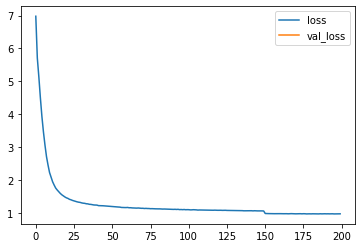

loss =  0.9683500528335571 val_loss =  None
136/136 [==============================] - 93s 683ms/step - loss: 0.9684 - lr: 1.0000e-03


In [ ]:
gpt3_model.fit(train_X_1, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

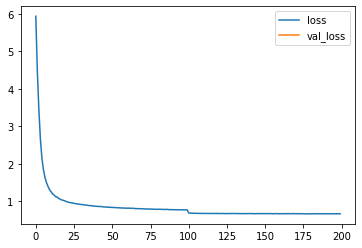

loss =  0.6714892983436584 val_loss =  None
136/136 [==============================] - 93s 685ms/step - loss: 0.6715 - lr: 1.0000e-03


In [ ]:
gpt3_model.fit(train_X_2, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

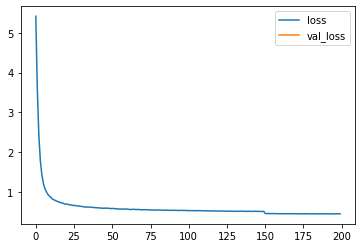

loss =  0.4505908787250519 , val_loss =  None
110/110 [==============================] - 75s 679ms/step - loss: 0.4506 - lr: 1.0000e-03


In [ ]:
gpt3_model.fit(train_X_3, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

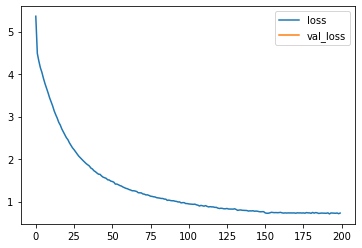

loss =  0.729282021522522 , val_loss =  None
110/110 [==============================] - 75s 680ms/step - loss: 0.7293 - lr: 1.0000e-04


In [ ]:
gpt3_model.fit(train_X_4, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

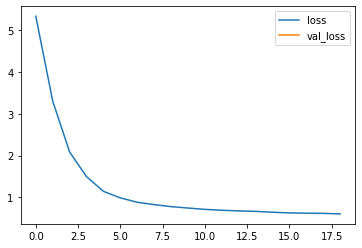

loss =  0.6041671633720398 , val_loss =  None
110/110 [==============================] - 75s 680ms/step - loss: 0.6042 - lr: 0.0100
Epoch 20/30
 16/110 [===>..........................] - ETA: 1:04 - loss: 0.5643

In [ ]:
gpt3_model.fit(train_X_5, train_y, epochs=30, batch_size=4, callbacks=[plot_losses, lr_scheduler])

# 10. Tokenize Test Input

In [ ]:
keyword = "별"
input_id = tokenizer.encode(keyword, return_tensors='tf')

# 11. Generate Poem

In [ ]:
import torch
with torch.no_grad():
  gen_id = gpt3_model.generate(input_id,
                               num_beams = 5,
                               do_sample = True,
                               min_length = 10, 
                               max_length=70, 
                               early_stopping=True,
                               pad_token_id=tokenizer.pad_token_id, 
                               eos_token_id=tokenizer.eos_token_id, 
                               bos_token_id=tokenizer.bos_token_id, 
                               repetition_penalty=3.0, 
                               top_k=50, 
                               top_p=0.95,
                               temperature=0.9, 
                               no_repeat_ngram_size=3
                               )
  gen_text = tokenizer.batch_decode(gen_id, skip_special_tokens=True)

In [ ]:
gen_text

['별 하늘 내 속 우리 님의 고운 눈썹을\n즈믄 밤의 꿈으로 맑게 씻어서르하늘에다 옮기어 심어 해놨더니 오늘동지자섣달 나르는 매서운 새가\n그걸 알고 시늉하며 비끼 마음 가네']

In [ ]:
  # gen_id = gpt3_model.generate(input_id, min_length = 5, max_length=180, temperature=0.9, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, bos_token_id=tokenizer.bos_token_id, repetition_penalty=2.0, top_k=50)


# 12. Model Save

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
gpt3_model.push_to_hub('gpt3_model')

Upload file tf_model.h5:   0%|          | 1.00/4.70G [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/MJ199999/gpt3_model
   d23f044..61ccba5  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/MJ199999/gpt3_model
   d23f044..61ccba5  main -> main



'https://huggingface.co/MJ199999/gpt3_model/commit/61ccba52016272ae8e51d397237aaad696bf5f16'